In [1]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow_addons;
!pip install -q sentencepiece;
!pip install -q tf-models-official;
!pip install -q tensorflow-text;
!pip install -q bert-for-tf2
!pip install -q sentencepiece

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 5.2 MB/s 
     |████████████████████████████████| 2.2 MB 5.4 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 352 kB 46.2 MB/s 
     |████████████████████████████████| 234 kB 49.8 MB/s 
     |████████████████████████████████| 90 kB 8.6 MB/s 
     |████████████████████████████████| 636 kB 36.6 MB/s 
     |████████████████████████████████| 47.8 MB 4.0 MB/s 
     |████████████████████████████████| 4.9 MB 20.8 MB/s 
     |████████████████████████████████| 462 kB 42.9 MB/s 
     |████████████████████████████████| 41 kB 110 kB/s 


In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib sizes and settings
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)

# TensorFlow libraries
%tensorflow_version 2.x 
import numpy as np
import tensorflow_addons as tfa
import tensorflow as tf
import tensorflow_hub as hub
import keras
import bert
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Base libraries
import matplotlib.pyplot as plt
random_seed = 81
import numpy as np
import pandas as pd
from os import listdir
import string
from tqdm import tqdm
import pickle
import os

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# spaCy
import spacy
nlp = spacy.load('en_core_web_sm')

# Gensim
import gensim

tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [4]:
def print_scores(label, pred):
  print(f'Accuracy_score: {accuracy_score(label, pred):.2f}', 
        f'f1_score: {f1_score(label, pred):.2f}', 
        f'recall_score: {recall_score(label, pred):.2f}', 
        f'precision_score: {precision_score(label, pred):.2f}', sep='\n', end='\n\n')

In [5]:
df_train = pd.read_csv('drive/My Drive/fake/w2v/newdata.csv')
df_train = df_train[['tweet', 'label']]
# df_train = df_train[df_train['text'].apply(lambda x: isinstance(x, str))]
print(df_train.shape)
df_train.head()

(6420, 2)


,tweet,label
0,the cdc currently reports deaths in general th...,1
1,states reported deaths a small rise from last ...,1
2,politically correct woman almost uses pandemic...,0
3,indiafightscorona we have covid testing labora...,1
4,populous states can generate large case counts...,1


In [6]:
df_test = pd.read_csv('drive/My Drive/fake/w2v/newdata_test.csv')
#y_sub = pd.read_csv(abspath_curr+'data/submit.csv')
#y_sub.drop('label', axis=1, inplace=True)
# df_test = df_test[df_test['text'].apply(lambda x: isinstance(x, str))]
print(len(df_test))

2140


In [7]:
print(df_train.shape)
print(df_train.dtypes)

(6420, 2)
tweet    object
label     int64
dtype: object


In [8]:
df_train['label'].value_counts()

1    3360
0    3060
Name: label, dtype: int64

Pre-processing Data (Tokenizaton and Word Embeddings)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(df_train[['tweet']], df_train[['label']], test_size=0.2, shuffle=True, random_state=81)


Apply GloVe Embeddings to Tokenized Text

In [10]:
def tokenizer_spacy(df, col, filename):
  # initialize list to be populated with the tokenized answers
  train_tokenized = []
  # Convert answers to a list
  train_list = df[col].values.tolist()
  # Loop through each answer
  for answer in tqdm(train_list):
      # empty string to populate with the chosen tokens
      tokens_joined = ''
      # spacy object pepares sentence to be parsed
      try:
        nlpd = nlp(answer)
        # for each word in answer
        for t in nlpd:
            # check that it is alphabetic, not a stopword, not punctuation and not a space
            if (t.is_alpha) and (not t.is_stop) and (not t.is_punct) and (not t.is_space):
                # if all conditions above are met, covert token back to string, normalize word to its Lemma, lower letter cases and add to empty string with a space behind it to keep words seperate
                tokens_joined += ' '+t.lemma_.lower()
        # append resulting string to the train_tokenized list
        train_tokenized.append(tokens_joined.strip())
      except:
        train_tokenized.append('Not processable')
  # save resulting file in pickle format
  pickle.dump(train_tokenized, open('drive/My Drive/fake/w2v/glove.pkl', 'wb'))
  return train_tokenized

In [11]:
tokenize = True
if tokenize == True:
  X_train_tok = tokenizer_spacy(X_train, 'tweet', 'X_train_tok')
  X_val_tok = tokenizer_spacy(X_val, 'tweet', 'X_val_tok')
  X_test_tok = tokenizer_spacy(df_test, 'tweet', 'X_test_tok')

100%|██████████| 2140/2140 [00:26<00:00, 82.00it/s]


Largest 10 lengths: [5832, 3123, 1449, 372, 316, 312, 289, 278, 273, 268]
median of lengths: 94.0
mean of lengths: 102.18321651090342


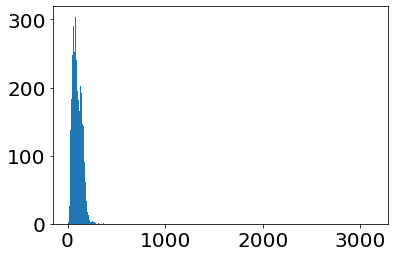

In [12]:
lens = [len(x) for x in X_train_tok]
lens = sorted(lens, reverse=True)
max_len = max(lens)
print('Largest 10 lengths:', lens[0:10])
print('median of lengths:', np.median(lens))
print('mean of lengths:', np.mean(lens))
plt.hist(lens[1:], bins=500)
plt.show()

In [13]:
max_len = 2000

In [14]:
# oov_token='<UNK>'
tok = tf.keras.preprocessing.text.Tokenizer()
tok.fit_on_texts(X_train_tok)
word_index = tok.word_index

train_seq = tok.texts_to_sequences(X_train_tok)
val_seq = tok.texts_to_sequences(X_val_tok)
test_seq =tok.texts_to_sequences(X_test_tok)

X_train_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(train_seq, maxlen=max_len)
X_val_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(val_seq, maxlen=max_len)
X_test_tok_padded = tf.keras.preprocessing.sequence.pad_sequences(test_seq, maxlen=max_len)

In [15]:
word_emb_w2v = {}
file_emb = open("drive/My Drive/fake/w2v/glove.6B.100d.txt", encoding="utf-8")
for emb in tqdm(file_emb):
  array = emb.split()
  word = str(array[0])
  vector = np.asarray(array[1:], dtype=np.float32)
  word_emb_w2v[word] = vector
file_emb.close()

400000it [00:13, 29285.35it/s]


In [16]:
num_o_words = len(word_index)+1
print(num_o_words)
emb_dim = 100 # size of w2v vector
emb_mtrx = np.zeros((num_o_words, emb_dim))

for word, i in word_index.items():
  if i > num_o_words:
    continue
  emb_vector = word_emb_w2v.get(word)
  if emb_vector is not None:
    emb_mtrx[i] = emb_vector

8168


Bi-directional RNN with LSTM cell

In [ ]:
model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=num_o_words, output_dim=emb_dim, input_length=max_len, 
                              embeddings_initializer = tf.keras.initializers.Constant(emb_mtrx), trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
print(model_rnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 100)         816800    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 909,601
Trainable params: 92,801
Non-trainable params: 816,800
_________________________________________________________________
None


In [ ]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("drive/My Drive/fake/w2v/model_rnn.h5", save_best_only=True,
                                                      save_weights_only=True)
# EarlyStopping callback
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# ReduceLROnPlateau callback
reduce_lr_on_plateau_cb = keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)

In [ ]:
model_rnn.compile(tf.keras.optimizers.Adam(learning_rate=0.0001) , loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                metrics=['accuracy'])

In [ ]:
history = model_rnn.fit(X_train_tok_padded, y_train.values, validation_data=(X_val_tok_padded, y_val.values), batch_size= 32, epochs=8,
                    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/8
161/161 [==============================] - 30s 136ms/step - loss: 0.6196 - accuracy: 0.5847 - val_loss: 0.4833 - val_accuracy: 0.7952 - lr: 1.0000e-04
Epoch 2/8
161/161 [==============================] - 22s 136ms/step - loss: 0.4155 - accuracy: 0.8041 - val_loss: 0.3709 - val_accuracy: 0.8201 - lr: 1.0000e-04
Epoch 3/8
161/161 [==============================] - 22s 135ms/step - loss: 0.3582 - accuracy: 0.8382 - val_loss: 0.3413 - val_accuracy: 0.8341 - lr: 1.0000e-04
Epoch 4/8
161/161 [==============================] - 22s 136ms/step - loss: 0.3303 - accuracy: 0.8522 - val_loss: 0.3202 - val_accuracy: 0.8512 - lr: 1.0000e-04
Epoch 5/8
161/161 [==============================] - 22s 138ms/step - loss: 0.3130 - accuracy: 0.8594 - val_loss: 0.3138 - val_accuracy: 0.8458 - lr: 1.0000e-04
Epoch 6/8
161/161 [==============================] - 22s 134ms/step - loss: 0.2975 - accuracy: 0.8662 - val_loss: 0.2971 - val_accuracy: 0.8660 - lr: 1.0000e-04
Epoch 7/8
161/161 [===============

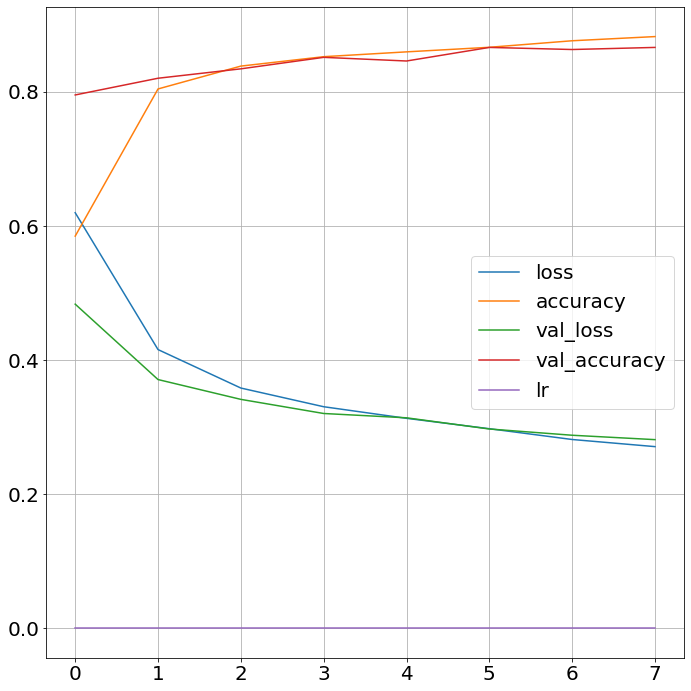

In [ ]:
# Create a figure
plot_hist = pd.DataFrame(history.history)
plot_hist.plot(figsize=(10, 10))
#plot_hist.to_csv(abspath_curr+'/plots/history.csv')
# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.legend(loc='best')
#plt.savefig(abspath_curr+'plots/history.png')
plt.show()

CNN and RNN with LSTM cell

In [ ]:
model_crnn = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=num_o_words, output_dim=emb_dim, input_length=max_len, 
                              embeddings_initializer = tf.keras.initializers.Constant(emb_mtrx), trainable=False),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
print(model_crnn.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2000, 100)         816800    
                                                                 
 conv1d (Conv1D)             (None, 2000, 128)         38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1000, 128)        0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [ ]:
# ModelCheckpoint callback
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="drive/My Drive/fake/w2v/model_crnn.h5", save_best_only=True,
                                                      save_weights_only=True)

In [ ]:
model_crnn.compile(tf.keras.optimizers.Adam(learning_rate=0.0001) , loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
                metrics=['accuracy'])

In [ ]:
history_crnn = model_crnn.fit(X_train_tok_padded, y_train.values, validation_data=(X_val_tok_padded, y_val.values), batch_size= 32, epochs=8,
                    callbacks=[model_checkpoint_cb, early_stopping_cb, reduce_lr_on_plateau_cb])

Epoch 1/8
161/161 [==============================] - 17s 55ms/step - loss: 0.5642 - accuracy: 0.6846 - val_loss: 0.3999 - val_accuracy: 0.8115 - lr: 1.0000e-04
Epoch 2/8
161/161 [==============================] - 11s 70ms/step - loss: 0.3610 - accuracy: 0.8363 - val_loss: 0.3292 - val_accuracy: 0.8505 - lr: 1.0000e-04
Epoch 3/8
161/161 [==============================] - 7s 43ms/step - loss: 0.3089 - accuracy: 0.8635 - val_loss: 0.3175 - val_accuracy: 0.8333 - lr: 1.0000e-04
Epoch 4/8
161/161 [==============================] - 8s 52ms/step - loss: 0.2781 - accuracy: 0.8758 - val_loss: 0.2885 - val_accuracy: 0.8746 - lr: 1.0000e-04
Epoch 5/8
161/161 [==============================] - 9s 55ms/step - loss: 0.2543 - accuracy: 0.8915 - val_loss: 0.2698 - val_accuracy: 0.8583 - lr: 1.0000e-04
Epoch 6/8
161/161 [==============================] - 9s 53ms/step - loss: 0.2317 - accuracy: 0.9036 - val_loss: 0.2588 - val_accuracy: 0.8808 - lr: 1.0000e-04
Epoch 7/8
161/161 [=========================

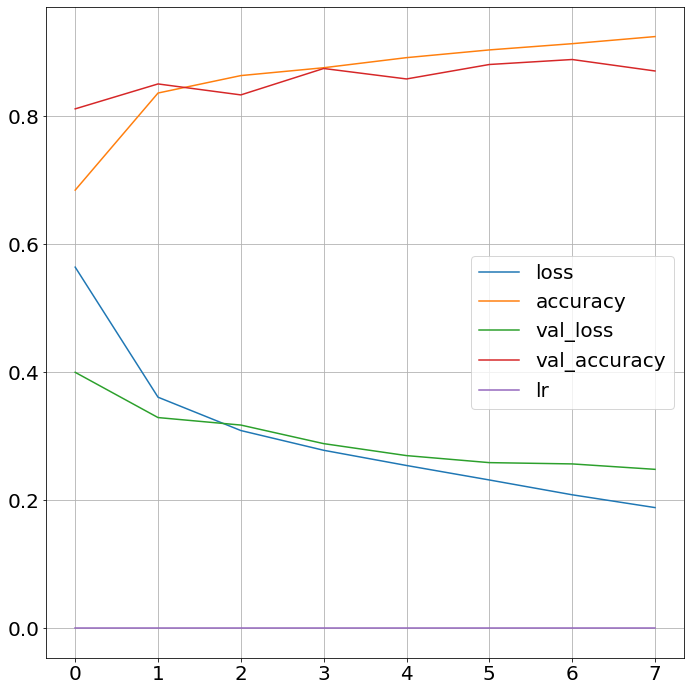

In [ ]:
# Create a figure
plot_hist = pd.DataFrame(history_crnn.history)
plot_hist.plot(figsize=(10, 10))
#plot_hist.to_csv(abspath_curr+'/plots/history_crnn.csv')
# Set grid
plt.grid(True)

# Save and show the figure
plt.tight_layout()
plt.legend(loc='best')
#plt.savefig(abspath_curr+'plots/history_crnn.png')
plt.show()

Pre-trained NNLM 128 Model

In [ ]:
# QNA only unbatched
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_tf = tf.data.Dataset.from_tensor_slices((X_train_tok, y_train.values.flatten())).batch(batch_size).prefetch(AUTOTUNE)
val_dataset_tf = tf.data.Dataset.from_tensor_slices((X_val_tok,y_val.values.flatten())).batch(batch_size).prefetch(AUTOTUNE)
test_dataset_tf = tf.data.Dataset.from_tensor_slices((X_test_tok)).batch(batch_size).prefetch(AUTOTUNE)

In [ ]:
# Get the model
import tensorflow_hub as hub
model_nnlm128 = keras.Sequential([hub.KerasLayer('https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1',
                                         trainable=False,
                                         dtype=tf.string,
                                         input_shape=[],
                                         output_shape=[128]),
                          keras.layers.Dense(128, activation='relu'),
                          keras.layers.Dropout(0.1),
                          keras.layers.Dense(1, activation='sigmoid')])

# Get the model summary
model_nnlm128.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124,659,329
Trainable params: 16,641
Non-trainable params: 124,642,688
_________________________________________________________________
